In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas_datareader import data as web
from datetime import datetime
import scipy.optimize as opt

In [2]:
plt.style.use('ggplot')

In [3]:
import yfinance as yf
from datetime import datetime, timedelta

symbols = ['AAPL', 'MSFT', 'GOOGL']
start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now()

data = yf.download(symbols,
                   start=start_date,
                   end=end_date,
                   progress=False)

In [4]:
data.head()

Price            Close                                High              \
Ticker            AAPL       GOOGL        MSFT        AAPL       GOOGL   
Date                                                                     
2024-02-15  182.995941  142.254318  404.288605  183.622985  143.001609   
2024-02-16  181.453201  140.012451  401.802582  183.981273  142.672805   
2024-02-20  180.706726  140.610275  400.539673  181.572633  141.566814   
2024-02-21  181.463165  142.035110  399.933044  182.030479  142.174604   
2024-02-22  183.503510  143.569534  409.350159  184.090748  144.476251   

Price                          Low                                Open  \
Ticker            MSFT        AAPL       GOOGL        MSFT        AAPL   
Date                                                                     
2024-02-15  406.844254  180.497743  139.952664  402.031298  182.687400   
2024-02-16  406.008960  180.816210  139.633819  401.186050  182.557985   
2024-02-20  402.230157  179.154060  138.986173  395.786379  180.935641   
2024-02-21  400.042446  179.810963  140.171855  395.000764  181.084946   
2024-02-22  410.523559  181.602498  142.284201  406.287380  182.617693   

Price                                 Volume                      
Ticker           GOOGL        MSFT      AAPL     GOOGL      MSFT  
Date                                                              
2024-02-15  142.622977  405.859794  65434500  37590700  21825500  
2024-02-16  142.473531  405.680787  49701400  31451100  22281100  
2024-02-20  139.155557  400.987141  53665600  25144700  24307900  
2024-02-21  140.939078  397.934295  41529700  23315700  18631100  
2024-02-22  144.406497  407.898324  52292200  27191900  27009900

In [5]:
adj_close = data['Close']
volume = data['Volume']

#Portfolio Analysis

In [6]:
def calc_returns(price_data, resample=None, ret_type="arithmatic"):
  if ret_type == "arithmatic":
    ret = price_data.pct_change().dropna()
  elif ret_type == "log":
    ret = np.log(price_data/price_data.shift()).dropna()
  else:
    raise ValueError("ret_type: return calculation type is not valid. use \"arithmatic\" or \"log\"")

  if resample != None:
    if ret_type=="arithmatic":
      ret = ret.resample(resample).apply(lambda df: (df+1).cumprod(axis=0).iloc[-1]) - 1
    elif ret_type=="log":
      ret = ret.resample(resample).apply(lambda df: df.sum(axis=0))

  return (ret)

def calc_returns_stats(returns):
  mean_returns = returns.mean()
  cov_matrix = returns.cov()
  return (mean_returns, cov_matrix)

def portfolio(weights, mean_returns, cov_matrix):
  portfolio_return = np.dot(weights.reshape(1,-1), mean_returns.values.reshape(-1,1))
  portfolio_var = np.dot(np.dot(weights.reshape(1,-1), cov_matrix.values), weights.reshape(-1,1))
  portfolio_std = np.sqrt(portfolio_var)

  return (np.squeeze(portfolio_return), np.squeeze(portfolio_var), np.squeeze(portfolio_std))


In [7]:
monthly_ret_arith = calc_returns(adj_close, resample='BM', ret_type='arithmatic')
monthly_ret_arith.head()

<ipython-input-6-2ae4a10b1309>:11: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  ret = ret.resample(resample).apply(lambda df: (df+1).cumprod(axis=0).iloc[-1]) - 1


Ticker,AAPL,GOOGL,MSFT
Date,,,
2024-02-29,-0.016915,-0.030188,0.017414
2024-03-29,-0.051286,0.090062,0.017116
2024-04-30,-0.006706,0.078513,-0.074610
2024-05-31,0.130222,0.059712,0.068191
2024-06-28,0.095553,0.057154,0.076651


In [8]:
monthly_ret_log = calc_returns(adj_close, resample='BM', ret_type='log')
monthly_ret_log.head()

<ipython-input-6-2ae4a10b1309>:13: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  ret = ret.resample(resample).apply(lambda df: df.sum(axis=0))


Ticker,AAPL,GOOGL,MSFT
Date,,,
2024-02-29,-0.017060,-0.030653,0.017265
2024-03-29,-0.052648,0.086235,0.016971
2024-04-30,-0.006729,0.075583,-0.077540
2024-05-31,0.122414,0.057998,0.065966
2024-06-28,0.091259,0.055580,0.073855


#Calculating the returns of an equally-weighted portfolio

In [9]:
equal_weights = np.array([1/len(symbols) for _ in range(len(symbols))])

mean_returns, cov_matrix = calc_returns_stats(monthly_ret_arith)
portfolio_return, portfolio_var, portfolio_std = portfolio(equal_weights, mean_returns, cov_matrix)

In [10]:
print("monthly portfolio return:\t%", round(100*portfolio_return.item(),2))
print("\nmonthly portfolio variance:\t%",round(100*portfolio_var.item(),2))
print("\nmean monthly returns of individual assets:\n",mean_returns)
print("\ncovariance matrix of assets returns:\n",cov_matrix)

monthly portfolio return:	% 1.6

monthly portfolio variance:	% 0.14

mean monthly returns of individual assets:
 Ticker
AAPL     0.022962
GOOGL    0.022834
MSFT     0.002228
dtype: float64

covariance matrix of assets returns:
 Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    0.003089 -0.000347  0.001353
GOOGL  -0.000347  0.004240  0.000344
MSFT    0.001353  0.000344  0.002262


#Monte Carlo Simulation
##Long-only fully invested portfolios

In [11]:
num_iter = 500000

portfolio_var_list = []
portfolio_ret_list = []
w_list = []

max_sharpe = 0
max_sharpe_var = None
max_sharpe_ret = None
max_sharpe_w = None

daily_ret = calc_returns(adj_close, resample=None, ret_type="log")
mean_returns, cov_matrix = calc_returns_stats(daily_ret)

for i in range(1, num_iter+1):
  rand_weights = np.random.random(len(symbols))
  rand_weights = rand_weights/np.sum(rand_weights)

  portfolio_ret, portfolio_var, portfolio_std = portfolio(rand_weights, mean_returns, cov_matrix)

  portfolio_ret = portfolio_ret * 252
  portfolio_var = portfolio_var * 252
  portfolio_std = portfolio_std * (252**0.5)

  sharpe = (portfolio_ret/(portfolio_var**0.5)).item()
  if sharpe > max_sharpe:
    max_sharpe = sharpe
    max_sharpe_var = portfolio_var.item()
    max_sharpe_ret = portfolio_ret.item()
    max_sharpe_w = rand_weights

  portfolio_var_list.append(portfolio_var)
  portfolio_ret_list.append(portfolio_ret)
  w_list.append(rand_weights)
  if ((i/num_iter)*100)%10 == 0:
    print(f'%{round((i/num_iter)*100)}...',end='')


%10...%20...%30...%40...%50...%60...%70...%80...%90...%100...

In [12]:
stat = np.hstack([np.array(portfolio_ret_list).reshape(-1,1),
                  np.array(portfolio_var_list).reshape(-1,1),
                  (np.array(portfolio_ret_list)/np.sqrt(np.array(portfolio_var_list))).reshape(-1,1)]
)
stat = pd.DataFrame(stat, columns=['Return', 'Variance', 'Sharpe ratio'])
stat.head()

,Return,Variance,Sharpe ratio
0,0.171337,0.035202,0.913201
1,0.131254,0.035148,0.700105
2,0.261008,0.044334,1.239617
3,0.108637,0.037292,0.562563
4,0.218703,0.050779,0.970543


In [13]:
min_vol = stat[stat['Variance'] == stat['Variance'].min()]
min_vol_index = min_vol.index.item()
min_vol_weights = w_list[min_vol_index]
print("Portfolio with minimum volatility:\n")
print(f"Annual Sharpe Ratio: {round(stat['Sharpe ratio'][min_vol_index],2)} | Annual Return: % {round(stat['Return'][min_vol_index]*100,2)} | Annual Volatility: % {round(stat['Variance'][min_vol_index]*100,2)}\n")
for index, symbol in enumerate(symbols):
  print(f'{symbols}:\t {round(min_vol_weights[index]*100,2)} %')

Portfolio with minimum volatility:

Annual Sharpe Ratio: 0.8 | Annual Return: % 14.93 | Annual Volatility: % 3.48

['AAPL', 'MSFT', 'GOOGL']:	 35.7 %
['AAPL', 'MSFT', 'GOOGL']:	 15.22 %
['AAPL', 'MSFT', 'GOOGL']:	 49.08 %


In [14]:
print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(max_sharpe,2)} | Annual Return: % {round(max_sharpe_ret*100,2)} | Annual Volatility: % {round(max_sharpe_var*100,2)}\n")
for index,symbol in enumerate(symbols):
  print(f'{symbol}:\t% {round(max_sharpe_w[index]*100,2)}')

Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 1.32 | Annual Return: % 27.77 | Annual Volatility: % 4.41

AAPL:	% 64.32
MSFT:	% 35.67
GOOGL:	% 0.01


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

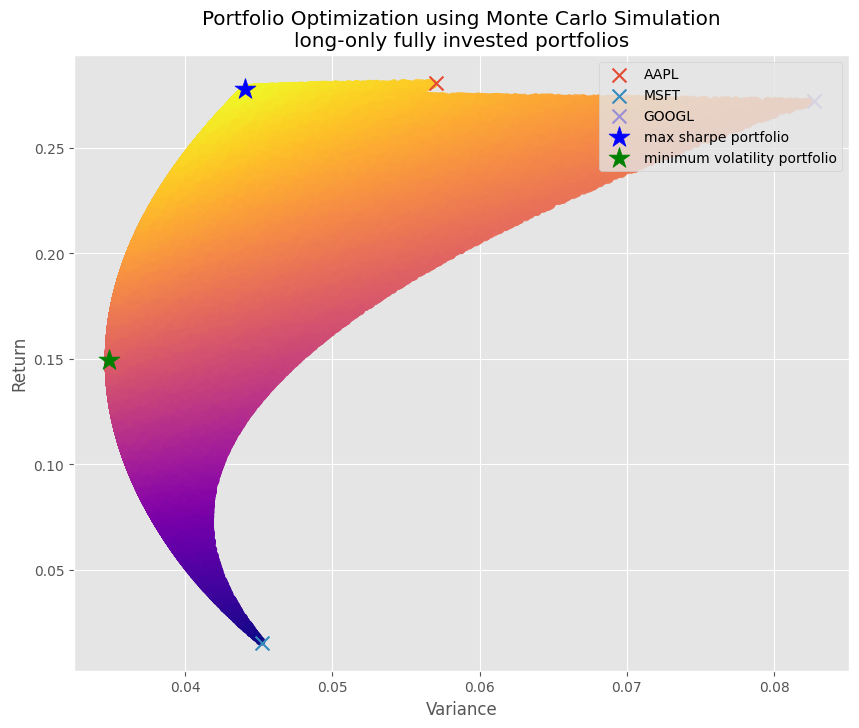

In [15]:
daily_ret_var = daily_ret.var()
plt.figure(figsize=(10,8))
plt.scatter(portfolio_var_list, portfolio_ret_list, c=stat['Sharpe ratio'], alpha=0.8, cmap='plasma')
for sym in symbols:
  plt.scatter(daily_ret_var.loc[sym]*252, mean_returns.loc[sym]*252, marker='x', s=100, label=sym)

plt.scatter([max_sharpe_var], [max_sharpe_ret], marker='*', s=250, label='max sharpe portfolio', c='blue')
plt.scatter(min_vol['Variance'].values, min_vol['Return'].values, marker='*', s=250, label='minimum volatility portfolio', c='green')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Portfolio Optimization using Monte Carlo Simulation\nlong-only fully invested portfolios')
plt.legend(loc='upper right')

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=stat['Sharpe ratio'].min(), vmax=stat['Sharpe ratio'].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Sharpe Ratio',);


#Optimization using scipy optimize module (Sequential Least Squares Programming)


In [16]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
  portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
  sr = ((portfolio_return - risk_free_rate)/portfolio_std) * (252**0.5)
  return (-sr)

def portfolio_variance(weights, mean_returns, cov_matrix):
  portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
  return (portfolio_var*252)

In [17]:
daily_ret = calc_returns(adj_close, resample=None, ret_type="log")
mean_returns, cov_matrix = calc_returns_stats(daily_ret)

In [18]:
def optimize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, w_bounds=(0,1)):
  "This function finds the portfolio weights which minimize the negative sharpe ratio"

  init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
  args = (mean_returns, cov_matrix, risk_free_rate)
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
  result = opt.minimize(fun=neg_sharpe_ratio,
                        x0=init_guess,
                        args=args,
                        method='SLSQP',
                        bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                        constraints=constraints,
                        )
  if result['success']:
     print(result['message'])
     opt_sharpe = - result['fun']
     opt_weights = result['x']
     opt_weights = result['x']
     opt_return, opt_variance, opt_std = portfolio(opt_weights, mean_returns, cov_matrix)
     return (opt_sharpe, opt_weights, opt_return.item()*252, opt_variance.item()*252, opt_std.item()*(252**0.5))
  else:
     print("Optimization operation was not successful!")
     print(result['message'])
     return (None)


In [19]:
opt_sharpe, opt_weights, opt_return, opt_variance, opt_std = optimize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0, w_bounds=(0,1))


Optimization terminated successfully


In [20]:
print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(opt_sharpe,2)} | Annual Return: % {round(opt_return*100, 2)} | Annual Volatility: % {round(opt_variance*100,2)}\n")
for index,symbol in enumerate(symbols):
  print(f'{symbol}:\t% {round(opt_weights[index]*100,2)}')


Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 1.32 | Annual Return: % 27.78 | Annual Volatility: % 4.41

AAPL:	% 64.79
MSFT:	% 35.21
GOOGL:	% 0.0


In [21]:
def minimize_portfolio_variance(mean_returns, cov_matrix, w_bounds=(0,1)):
  "This function finds the portfolio weights which minimize the portfolio volatility(variance)"

  init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
  args = (mean_returns, cov_matrix)
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
  result = opt.minimize(fun=portfolio_variance,
                        x0=init_guess,
                        args=args,
                        method='SLSQP',
                        bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                        constraints=constraints,
                        )

  if result['success']:
    print(result['message'])
    min_var = result['fun']
    min_var_weights = result['x']
    min_var_return, min_var_variance, min_var_std = portfolio(min_var_weights, mean_returns, cov_matrix)
    min_var_sharpe = (min_var_return/min_var_std)*(252**0.5)
    return (min_var_sharpe, min_var_weights, min_var_return.item()*252, min_var_variance.item()*252, min_var_std.item()*(252**0.5))
  else:
    print("Optimization operation was not successful!")
    print(result['message'])
    return (None)


In [22]:
min_var_sharpe, min_var_weights, min_var_return, min_var_variance, min_var_std = minimize_portfolio_variance(mean_returns, cov_matrix, w_bounds=(0,1))


Optimization terminated successfully


In [23]:
print("Portfolio with maximum sharpe ratio:\n")
print(f"Annual Sharpe Ratio: {round(min_var_sharpe,3)} | Annual Return: % {round(min_var_return*100,2)} | Annual Volatility: % {round(min_var_variance*100,3)}\n")
for index,symbol in enumerate(symbols):
  print(f'{symbols}:\t% {round(min_var_weights[index]*100,2)}')


Portfolio with maximum sharpe ratio:

Annual Sharpe Ratio: 0.799 | Annual Return: % 14.92 | Annual Volatility: % 3.485

['AAPL', 'MSFT', 'GOOGL']:	% 35.7
['AAPL', 'MSFT', 'GOOGL']:	% 15.18
['AAPL', 'MSFT', 'GOOGL']:	% 49.12


#Minimum Variance Portfolio (MVP)

In [24]:
def calc_portfolio_return(weights, mean_returns, cov_matrix):
  portfolio_return, portfolio_var, portfolio_std = portfolio(weights, mean_returns, cov_matrix)
  return (portfolio_return.item()*252)

def efficient_portfolio(mean_returns, cov_matrix, target_return, w_bounds=(0,1)):
  init_guess = np.array([1/len(mean_returns) for _ in range(len(mean_returns))])
  args = (mean_returns, cov_matrix)
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                 {'type': 'eq', 'fun': lambda x: 252*np.squeeze(np.dot(x.reshape(1,-1),mean_returns.values.reshape(-1,1))) - target_return})
  result = opt.minimize(fun=portfolio_variance,
                        x0=init_guess,
                        args=args,
                        method='SLSQP',
                        bounds=tuple(w_bounds for _ in range(len(mean_returns))),
                        constraints=constraints,
                        )
  if not result['success']:
     print(result['message'])
  efficient_variance = result['fun']
  efficient_weights = result['x']
  efficient_return, _ , efficient_std = portfolio(efficient_weights, mean_returns, cov_matrix)
  efficient_sharpe = (efficient_return/efficient_return)*(252**0.5)
  return (efficient_sharpe, efficient_weights, efficient_return.item()*252, efficient_variance, efficient_std.item()*(252**0.5))



In [25]:
expected_return = 0.3
efficient_sharpe, efficient_weights, efficient_return, efficient_variance, efficient_std = efficient_portfolio(mean_returns,
                                                                                                               cov_matrix,
                                                                                                               target_return = expected_return,
                                                                                                               w_bounds=(0,1)
                                                                                                               )


Positive directional derivative for linesearch


In [26]:
print("Efficient portfolio for 30% return level:\n")
print(f"Annual Sharpe Ratio: {round(efficient_sharpe, 3)} | Annual Return: % {round(efficient_return*100,2)} | Annual Volatility: % {round(efficient_variance*100,3)}\n")
for index,symbol in enumerate(symbols):
  print(f'{symbols}:\t% {round(efficient_weights[index]*100,2)}')

Efficient portfolio for 30% return level:

Annual Sharpe Ratio: 15.875 | Annual Return: % 28.09 | Annual Volatility: % 5.701

['AAPL', 'MSFT', 'GOOGL']:	% 100.0
['AAPL', 'MSFT', 'GOOGL']:	% 0.0
['AAPL', 'MSFT', 'GOOGL']:	% 0.0


#Efficient Frontier

Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive directional derivative for linesearch
Positive dire

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

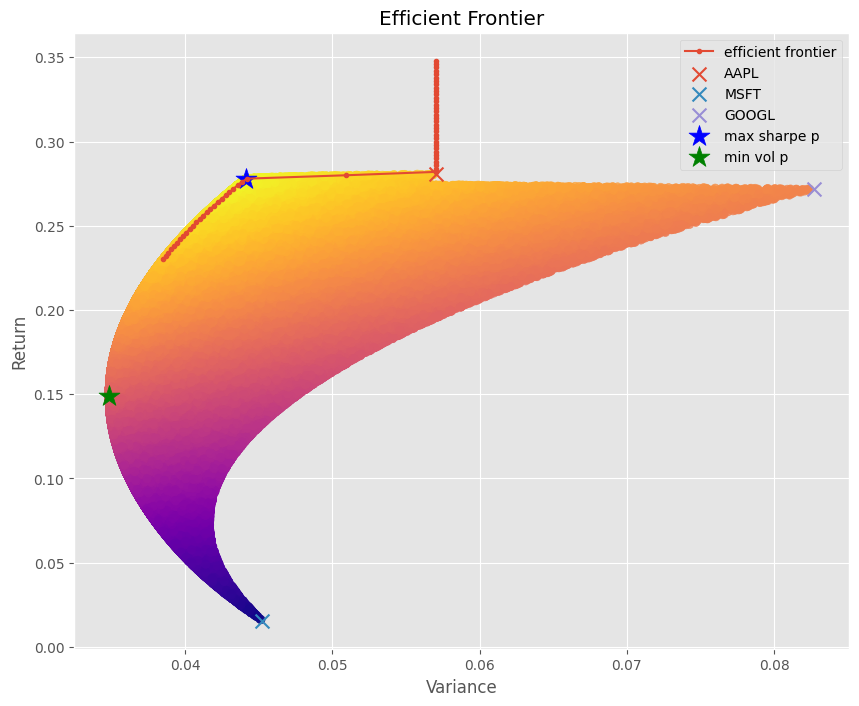

In [28]:
daily_ret_var = daily_ret.var()
plt.figure(figsize=(10,8))

target_rets = np.arange(0.23,0.35,0.002)
efficient_vars = np.array([efficient_portfolio(mean_returns,cov_matrix,target_return=x,w_bounds=(0,1))[3] for x in target_rets])
plt.plot(efficient_vars,target_rets,marker='.',label="efficient frontier")

plt.scatter(portfolio_var_list,portfolio_ret_list,c=stat['Sharpe ratio'], alpha=0.8, cmap='plasma')
for sym in symbols:
  plt.scatter(daily_ret_var.loc[sym]*252, mean_returns.loc[sym]*252, marker='x', s=100, label=sym)

plt.scatter([opt_variance], [opt_return], marker='*', s=250, label='max sharpe p', c='blue')
plt.scatter(min_var_variance, min_var_return, marker='*',s=250, label='min vol p', c='green')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend(loc='upper right')

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=stat['Sharpe ratio'].min(), vmax=stat['Sharpe ratio'].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Sharpe Ratio',);
